# EV Battery Performance Analytics - Capstone Project

## Import Libraries

In [1]:
# Import necessary libraries
import pickle as pkl
from tqdm import tqdm
from glob import glob
import torch
import pandas as pd
import numpy as np 
from collections import OrderedDict
import h5py
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
from natsort import natsorted
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Read the dataset, downsample using PCA and store the results in pkl file

In [2]:
# Set the path to the dataset
datasetspath = "/Users/saransathy/WalshDBA/Capstone"
# Read all etron dataset files
#etron_chargedata_files = glob(f"{datasetspath}/Charge/*/Raw.mat")
#etron_drivedata_files = glob(f"{datasetspath}/Drive/*/Raw.mat")

### Function to read Large Multivehicle Data and perform Temporal Dimenstion Reduction

In [3]:
# Function to read multivehicle data files
def read_mv_data_files(dataset):
    data_files = natsorted(glob(f"{datasetspath}/{dataset}/data/*.pkl"))
    datadict = OrderedDict((key,[]) for key in ['Label','Car','ChargeSegment','Mileage','Capacity','V1','V2','V3','V4','V5','V6','V7','V8','ExpVar'])
    for each_path in tqdm(data_files):
        # Load the pickle file
        # Use 'rb' mode to read the file in binary format
        f = open(each_path, 'rb')
        # Load the data using torch.load
        # Set weights_only=False to load the entire file
        this_pkl_file = torch.load(f, weights_only=False)
        # Assuming the pickle file contains a tuple with data and metadata
        metadata = this_pkl_file[1]
        # Append metadata to the datadict
        datadict['Label'].append(int(metadata['label'][0]))
        datadict['Car'].append(int(metadata['car']))
        datadict['ChargeSegment'].append(int(metadata['charge_segment']))
        datadict['Mileage'].append(metadata['mileage'])
        datadict['Capacity'].append(metadata['capacity'])
        # Standardize features (important for PCA)
        scaler = StandardScaler()
        chargingdata_scaled = scaler.fit_transform(this_pkl_file[0].T)
        # Perform PCA
        pca = PCA(n_components=1)  # Reduce to 1 dimension so that 128 snippets can be covered to 1
        principal_components = pca.fit_transform(chargingdata_scaled)
        # Append the first 8 principal components and explained variance to the datadict
        for i in range(8):
            datadict[f'V{i+1}'].append(principal_components[i,0])
        datadict['ExpVar'].append(pca.explained_variance_ratio_[0])
        # Close the file & delete variables to free memory
        f.close()
        del this_pkl_file,f,metadata,scaler,chargingdata_scaled,pca,principal_components 
    del data_files
    return pd.DataFrame(datadict)

### Function to read Audi eTron Dataset and Perform Temporal Dimension Reduction

In [9]:
# Function to read etron data files
def read_etron_data_files(dataset):

    # Function to extract data from the h5py file
    def extract_group(f, path):
        if isinstance(f[path], h5py.Group):
            return {k: extract_group(f, f"{path}/{k}") for k in f[path].keys()}
        else:
            return np.array(f[path])
        
    # Process the data files
    data_files = natsorted(glob(f"{datasetspath}/{dataset}/*/Raw.mat"))
    datadict = OrderedDict()
    for each_path in tqdm(data_files):
        print(each_path)
        # Load the .mat file
        f = h5py.File(each_path, 'r')
        # Extract the relevant data
        data = extract_group(f, 'Raw')
        for key in data.keys():
            if key not in datadict:
                datadict[key] = []
            datadict[key].extend(data[key][0])
        f.close()
        del data
    return(datadict)

In [ ]:
# Function to read etron data files
def read_etron_data_files(dataset):

    # Function to extract data from the h5py file
    def extract_group(f, path):
        if isinstance(f[path], h5py.Group):
            return {k: extract_group(f, f"{path}/{k}") for k in f[path].keys()}
        else:
            return np.array(f[path])
        
    # Process the data files
    data_files = natsorted(glob(f"{datasetspath}/{dataset}/*/Raw.mat"))
    datadict = OrderedDict()
    for each_path in tqdm(data_files):
        print(each_path)
        # Load the .mat file
        f = h5py.File(each_path, 'r')
        # Extract the relevant data
        data = extract_group(f, 'Raw')
        for key in data.keys():
            datadict[key].extend(data[key][0])
        
        #print(data)
        starttime = min(min(data['TimeCurr'][0]), min(data['TimeVolt'][0]), min(data['TimeSoC'][0]), min(data['TimeTemp'][0]))
        endtime = max(max(data['TimeCurr'][0]), max(data['TimeVolt'][0]), max(data['TimeSoC'][0]), max(data['TimeTemp'][0]))
        #print(starttime, endtime)
        #print('Window Length:', (endtime - starttime)/60, 'minutes')
        windowdict = OrderedDict((key,[]) for key in ['Curr','Volt','SoC','Temp'])
        timedict = OrderedDict((key,[]) for key in ['Curr','Volt','SoC','Temp'])
        i = starttime
        while i <= endtime:
            curr = data['Curr'][0][(data['TimeCurr'][0]>=starttime) & (data['TimeCurr'][0]<starttime+1280)]

            windowdict['Curr'].extend(data['Curr'][0][(data['TimeCurr'][0]>=i) & (data['TimeCurr'][0]<i+1280)])
            windowdict['Volt'].extend(data['Volt'][0][(data['TimeVolt'][0]>=i) & (data['TimeVolt'][0]<i+1280)])
            windowdict['SoC'].extend(data['SoC'][0][(data['TimeSoC'][0]>=i) & (data['TimeSoC'][0]<i+1280)])
            windowdict['Temp'].extend(data['Temp'][0][(data['TimeTemp'][0]>=i) & (data['TimeTemp'][0]<i+1280)])
            df = pd.DataFrame({k: pd.Series(v) for k, v in windowdict.items()})
            df = df.fillna(method='ffill').fillna(method='bfill')
            #print(df)
            scaler = StandardScaler()
            data_scaled = scaler.fit_transform(df)
            #print(data_scaled)
            # Perform PCA
            pca = PCA(n_components=1)
            principal_components = pca.fit_transform(data_scaled.T)
            #print(principal_components)
            # Append the first 8 principal components and explained variance to the datadict
            datadict['ExpVar'].append(pca.explained_variance_ratio_[0])
            datadict['Curr'].append(principal_components[0,0])
            datadict['Volt'].append(principal_components[1,0])
            datadict['SoC'].append(principal_components[2,0])
            datadict['Temp'].append(principal_components[3,0])
            i += 1280
            del df, scaler, data_scaled, pca, principal_components
        #continue
        #min_len = min(data['Curr'].shape[1], data['Volt'].shape[1], data['SoC'].shape[1], data['Temp'].shape[1])
        #print(min_len)
        #df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})
        # Standardize features (important for PCA)
        #for key in ['Curr','Volt','SoC','Temp']:
        #    print(key)
        #    scaler = StandardScaler()
        #    data_scaled = scaler.fit_transform(data[key])
        #    # Perform PCA
        #    pca = PCA(n_components=int(min_len/2))
        #    principal_components = pca.fit_transform(data_scaled)
        #    print(principal_components.shape, pca.explained_variance_ratio_[0])
        #    print("########################################")
        #    datadict[key].extend(principal_components[:,0])
        #    vardict[key].append(pca.explained_variance_ratio_[0])
        # Close the file & delete variables to free memory
        f.close()
        del f, starttime, endtime, windowdict, data
    return (pd.DataFrame(datadict))

In [ ]:
# Define the columns for the etron datasets
etron_data_columns = ['TimeStamp','TotalCurrent','AvgCuurent','AvgVoltage','AvgSOC','AvgTemp',
                      'MinCurrent','MaxCurrent','MinVoltage',
                      'MaxVoltage','MinTemp','MaxTemp','MinSOC','MaxSOC']

# Function to extract data from the h5py file
def extract_group(f, path):
    if isinstance(f[path], h5py.Group):
        return {k: extract_group(f, f"{path}/{k}") for k in f[path].keys()}
    else:
        return np.array(f[path])

# Function to get data indexes for a given key within a specified time range
def get_data_idxs(key, data, starttime, stoptime):
    """
    Extracts data indexes for a given key within the specified time range.
    """
    mask = (data[key][0] > starttime) & (data[key][0] <= stoptime)
    idxs = np.where(mask)[0]
    return list(idxs)

# Function to get the timestamp range from the epochs and elapsed times
def get_timestamp_range(epochs, elapsed_times):
    """
    Returns the minimum and maximum timestamps from the data.
    """
    timeranges = [(0,elapsed_times[0],epochs[0])] # Time range is a tuple of (start, end)
    for i in range(0, len(epochs)):
        if (i and (epochs[i] != epochs[i-1])):
            timeranges.append((elapsed_times[i-1], elapsed_times[i],epochs[i]))
    if timeranges[-1][2] != epochs[-1]:
        # If the last epoch is different, add it to the timeranges
        timeranges.append((elapsed_times[-1], float('inf'),epochs[i]))
    else:
        # If the last epoch is the same, just extend the end time
        timeranges[-1] = (timeranges[-1][0], float('inf'), epochs[i])
    return timeranges

# Function to read etron data files
def read_etron_data_files(dataset):
    data_files = glob(f"{datasetspath}/{dataset}/*/Raw.mat")
    datadict = OrderedDict((key,[]) for key in etron_data_columns)
    for each_path in tqdm(data_files):
        # Load the .mat file
        f = h5py.File(each_path, 'r')
        # Extract the relevant data
        data = extract_group(f, 'Raw')
        print(data)
        # Get the epochs and elapsed times
        timeranges = get_timestamp_range(data['Epoch'][0], data['TimeEpoch'][0])
        # for each time range, calculate the required statistics
        for startelapse,stopelapse,epoch in timeranges:
            print(startelapse, stopelapse, epoch)
            datadict['TimeStamp'].append(datetime.fromtimestamp(epoch).strftime('%Y-%m-%d %H:%M:%S'))
            idxs = get_data_idxs('TimeCurr', data, startelapse, stopelapse)
            if len(idxs):
                datadict['TotalCurrent'].append(np.sum(data['Curr'][0][idxs] > 0))
                datadict['AvgCuurent'].append(np.mean(data['Curr'][0][idxs] > 0))
                datadict['MinCurrent'].append(np.min(data['Curr'][0][idxs]))
                datadict['MaxCurrent'].append(np.max(data['Curr'][0][idxs]))
            idxs = get_data_idxs('TimeVolt', data, startelapse, stopelapse)
            if len(idxs):
                datadict['AvgVoltage'].append(np.mean(data['Volt'][0][idxs]))
                datadict['MinVoltage'].append(np.min(data['Volt'][0][idxs]))
                datadict['MaxVoltage'].append(np.max(data['Volt'][0][idxs]))
            idxs = get_data_idxs('TimeSoC', data, startelapse, stopelapse)
            if len(idxs):
                datadict['AvgSOC'].append(np.mean(data['SoC'][0][idxs]))
                datadict['MinSOC'].append(np.min(data['SoC'][0][idxs]))
                datadict['MaxSOC'].append(np.max(data['SoC'][0][idxs]))
            idxs = get_data_idxs('TimeTemp', data, startelapse, stopelapse)
            if len(idxs):
                datadict['AvgTemp'].append(np.mean(data['Temp'][0][idxs]))
                datadict['MinTemp'].append(np.min(data['Temp'][0][idxs]))
                datadict['MaxTemp'].append(np.max(data['Temp'][0][idxs]))
        # Close the file & delete variables to free memory
        f.close()
        del f, data, timeranges
    return pd.DataFrame(datadict)

In [4]:
# Read all multivehicle dataset files for the first time and store it pkl file for future use
# Uncomment the below lines only for the first time use
# ev1_df = read_mv_data_files("battery_dataset1")
# ev2_df = read_mv_data_files("battery_dataset2")
# ev3_df = read_mv_data_files("battery_dataset3")
# pd.to_pickle({"ev1_df": ev1_df, "ev2_df": ev2_df, "ev3_df": ev3_df}, f"{datasetspath}/mv_evdataset.pkl")


In [10]:
td = read_etron_data_files('Charge')

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/saransathy/WalshDBA/Capstone/Charge/Folder1/Raw.mat


 12%|█▎        | 1/8 [00:00<00:04,  1.65it/s]

/Users/saransathy/WalshDBA/Capstone/Charge/Folder3/Raw.mat


 25%|██▌       | 2/8 [00:01<00:02,  2.07it/s]

/Users/saransathy/WalshDBA/Capstone/Charge/Folder5/Raw.mat
/Users/saransathy/WalshDBA/Capstone/Charge/Folder7/Raw.mat


 50%|█████     | 4/8 [00:02<00:02,  1.80it/s]

/Users/saransathy/WalshDBA/Capstone/Charge/Folder9/Raw.mat


 62%|██████▎   | 5/8 [00:06<00:05,  1.72s/it]

/Users/saransathy/WalshDBA/Capstone/Charge/Folder11/Raw.mat


 75%|███████▌  | 6/8 [00:07<00:02,  1.34s/it]

/Users/saransathy/WalshDBA/Capstone/Charge/Folder13/Raw.mat


 88%|████████▊ | 7/8 [00:15<00:03,  3.57s/it]

/Users/saransathy/WalshDBA/Capstone/Charge/Folder15/Raw.mat


100%|██████████| 8/8 [00:17<00:00,  2.21s/it]


In [17]:
df = pd.DataFrame({k: pd.Series(v) for k, v in td.items()})

In [18]:
df.shape

(90537351, 10)

In [22]:
df.isna().sum()

Curr             1251
Epoch        90506500
SoC                 0
Temp         88726891
TimeCurr         1251
TimeEpoch    90506500
TimeSoC             0
TimeTemp     88726891
TimeVolt         1251
Volt             1251
dtype: int64

In [ ]:
df[(df['TimeSoC']==df['TimeVolt']) & (df['TimeCurr'] == df['TimeVolt'])].isna().sum()

Curr               0
Epoch        4068015
SoC                0
Temp         2288406
TimeCurr           0
TimeEpoch    4068015
TimeSoC            0
TimeTemp     2288406
TimeVolt           0
Volt               0
dtype: int64

: 

In [ ]:
cleandata = df[df['TimeCurr']==df['TimeVolt']].drop(['TimeVolt', 'TimeSoC', 'TimeTemp','Epoch','TimeEpoch'],axis=1).fillna(method='ffill').fillna(method='bfill')

In [32]:
cleandata.fillna(method='ffill').fillna(method='bfill')

,Curr,SoC,Temp,TimeCurr,Volt
0,-0.0,86.00,26.5,1.241296e+04,436.75
1,-0.0,86.00,26.5,1.241297e+04,436.75
2,-0.0,86.00,26.5,1.241298e+04,437.00
3,-0.0,86.00,26.5,1.241299e+04,436.75
4,-0.0,86.00,26.5,1.241300e+04,436.75
...,...,...,...,...,...
90536095,-0.0,67.05,20.0,4.719412e+06,416.25
90536096,-0.0,67.05,20.0,4.719412e+06,416.25
90536097,-0.0,67.05,20.0,4.719412e+06,416.25
90536098,-0.0,67.05,20.0,4.719412e+06,416.25


In [33]:
cleandata.sample(10)

,Curr,SoC,Temp,TimeCurr,Volt
71575159,-1.0,73.10,NaN,4.641983e+06,424.25
47825275,-1.0,95.60,NaN,4.242030e+06,450.00
78454862,-1.0,48.30,NaN,4.735134e+06,397.50
44433971,-1.0,92.30,NaN,4.190627e+06,446.25
88747836,-12.0,88.05,NaN,3.320087e+06,442.25
15461048,-1.0,73.55,NaN,5.457155e+04,424.00
40502429,-96.0,95.75,NaN,3.707150e+06,457.25
22240757,-2.0,86.55,NaN,1.243431e+05,439.75
9693337,-12.0,82.50,NaN,2.392748e+06,434.50
88619142,-12.0,86.15,NaN,3.318800e+06,440.00


## Load the dataset from the stored pickle file for further analysis

In [5]:
# Load all multivehicle dataset files from pkl
mv_evdataset = pd.read_pickle(f"{datasetspath}/mv_evdataset.pkl")
ev1_df = mv_evdataset["ev1_df"]
ev2_df = mv_evdataset["ev2_df"]
ev3_df = mv_evdataset["ev3_df"]
del mv_evdataset

## Exploratory Data Analytics

### Standard Scalar Transformation

In [6]:
# Perform scalar transformation
scaler = StandardScaler()
ev1_df[['Mileage','Capacity','V1','V2','V3','V4','V5','V6','V7','V8']] = scaler.fit_transform(ev1_df[['Mileage','Capacity','V1','V2','V3',
                                                                                                      'V4','V5','V6','V7','V8']])
ev2_df[['Mileage','Capacity','V1','V2','V3','V4','V5','V6','V7','V8']] = scaler.fit_transform(ev2_df[['Mileage','Capacity','V1','V2','V3',
                                                                                                      'V4','V5','V6','V7','V8']])
ev3_df[['Mileage','Capacity','V1','V2','V3','V4','V5','V6','V7','V8']] = scaler.fit_transform(ev3_df[['Mileage','Capacity','V1','V2','V3',
                                                                                                      'V4','V5','V6','V7','V8']])

### Explore data samples

In [7]:
# Understand the shape of the datasets
print(f"Manufacturer 1 Dataset Shape: {ev1_df.shape}")
print(f"Manufacturer 2 Dataset Shape: {ev2_df.shape}")
print(f"Manufacturer 3 Dataset Shape: {ev3_df.shape}")

Manufacturer 1 Dataset Shape: (629121, 14)
Manufacturer 2 Dataset Shape: (472829, 14)
Manufacturer 3 Dataset Shape: (176327, 14)


In [8]:
# Looks at the first 10 rows of Multivehicle datasets
ev1_df.head(5)

,Label,Car,ChargeSegment,Mileage,Capacity,V1,V2,V3,V4,V5,V6,V7,V8,ExpVar
0,0,0,1,-0.475662,-1.116194,2.153806,-0.977834,-1.095005,2.160050,2.125454,-0.098268,-0.479304,0.839140,0.951610
1,0,0,1,-0.475662,-1.116194,1.438602,-1.454099,0.273880,1.444772,1.394176,0.203541,-0.088355,-0.472319,0.930355
2,0,0,2,-0.472368,-1.116194,3.020190,-1.574150,-2.080272,3.023233,3.003028,0.681270,0.702383,0.427448,0.945939
3,0,0,2,-0.472368,-1.116194,2.680784,-2.888734,0.120678,2.686221,2.646919,1.265011,1.263010,-2.315946,0.903143
4,0,0,3,-0.469670,-1.116194,2.355877,0.041970,-1.909164,2.361719,2.336556,-1.116740,-1.248986,1.822512,0.966820


In [9]:
ev2_df.head(5)

,Label,Car,ChargeSegment,Mileage,Capacity,V1,V2,V3,V4,V5,V6,V7,V8,ExpVar
0,0,300,1,-1.907796,-0.867172,1.971855,-0.382165,-0.741603,1.975346,1.972599,-1.164862,-1.186918,1.210434,0.956432
1,0,300,2,-1.907796,-0.867172,2.632860,-3.044817,0.785778,2.635022,2.634816,1.107375,0.918928,-3.020777,0.893822
2,0,300,2,-1.907796,-0.867172,-0.215376,-0.444890,1.423995,-0.213284,-0.211725,-0.194424,-0.585374,-1.204403,0.914523
3,0,300,3,-1.897237,-0.867172,3.135781,-2.201414,-1.722851,3.139661,3.135435,1.494137,0.722169,0.205079,0.950878
4,0,300,3,-1.897237,-0.867172,3.585907,-3.672943,-0.176676,3.591687,3.586386,1.761445,1.180058,-2.121703,0.925163


In [10]:
ev3_df.head(5)

,Label,Car,ChargeSegment,Mileage,Capacity,V1,V2,V3,V4,V5,V6,V7,V8,ExpVar
0,1,500,0,-0.928357,-0.479099,-0.118986,0.781574,-1.402074,-0.120398,-0.113186,0.362885,0.430956,1.528180,0.945577
1,1,500,0,-0.928357,-0.479099,-0.118983,0.781575,-1.402073,-0.120395,-0.113183,0.362881,0.430952,1.528180,0.945577
2,1,500,0,-0.928357,-0.479099,-0.115359,0.782732,-1.401138,-0.116778,-0.109578,0.357538,0.425772,1.529036,0.945581
3,1,500,0,-0.928357,-0.479099,-0.106050,0.785569,-1.397492,-0.107488,-0.100326,0.341847,0.410436,1.533842,0.945678
4,1,500,0,-0.928357,-0.479099,-0.096717,0.788414,-1.393846,-0.098175,-0.091050,0.326141,0.395086,1.538611,0.945774


### Understand Explained Variance due to downsampling 

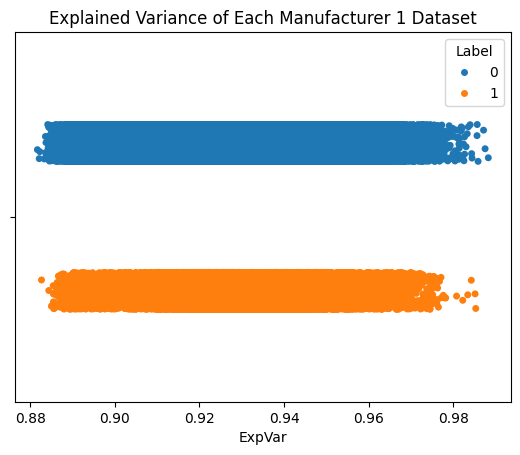

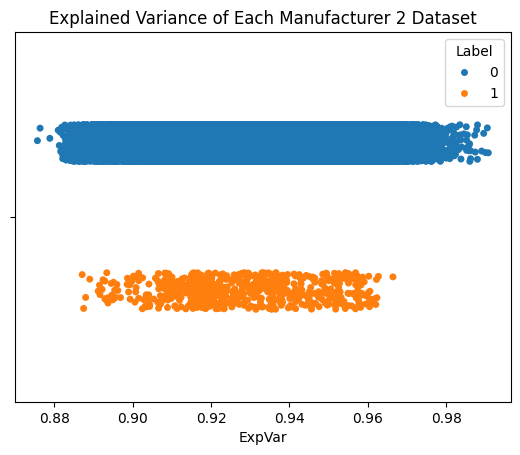

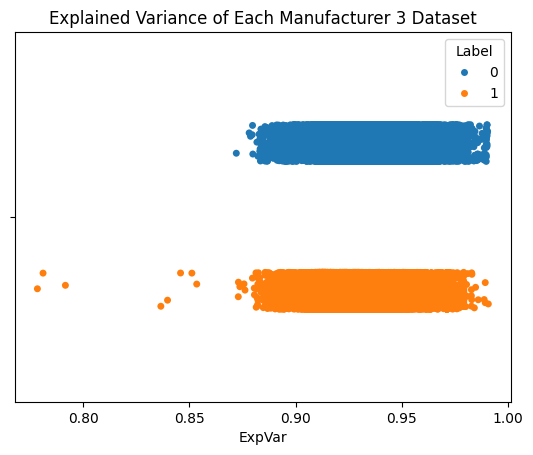

In [11]:
# Plot the explained variance of each manufacturer Dataset to visualize the variance captured by the principal component'ArithmeticError
sns.stripplot(x='ExpVar', hue='Label', data=ev1_df, dodge=True)
plt.title('Explained Variance of Each Manufacturer 1 Dataset')
plt.show()
sns.stripplot(x='ExpVar', hue='Label', data=ev2_df, dodge=True)
plt.title('Explained Variance of Each Manufacturer 2 Dataset')
plt.show()
sns.stripplot(x='ExpVar', hue='Label', data=ev3_df, dodge=True)
plt.title('Explained Variance of Each Manufacturer 3 Dataset')
plt.show()

### Observe Data Distribution

In [12]:
labels = ['Manufacturer 1', 'Manufacturer 2', 'Manufacturer 3']

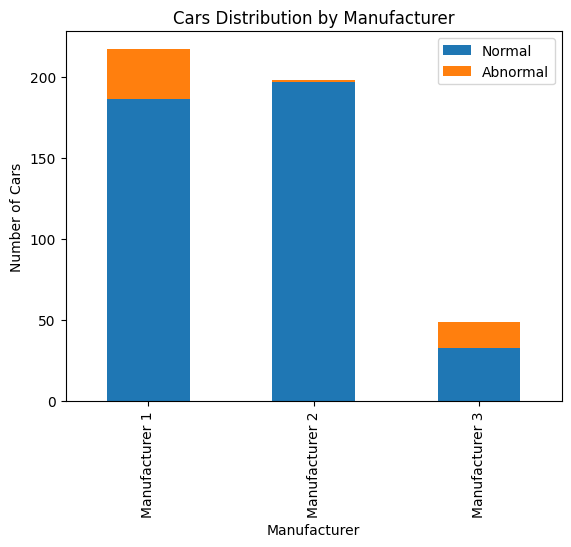

In [13]:
# Plot the distribution of normal and abnormal cars across manufacturers
NormalSamples = [ev1_df[ev1_df['Label']==0]['Car'].unique().size, 
              ev2_df[ev2_df['Label']==0]['Car'].unique().size, 
              ev3_df[ev3_df['Label']==0]['Car'].unique().size]
AbnormalSamples = [ev1_df[ev1_df['Label']!=0]['Car'].unique().size,
                ev2_df[ev2_df['Label']!=0]['Car'].unique().size, 
                ev3_df[ev3_df['Label']!=0]['Car'].unique().size]
samples_df = pd.DataFrame({'Normal': NormalSamples, 'Abnormal':AbnormalSamples}, index=labels)
samples_df.plot(kind='bar', stacked=True)
plt.title('Cars Distribution by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Cars')
plt.show()
del NormalSamples, AbnormalSamples, samples_df

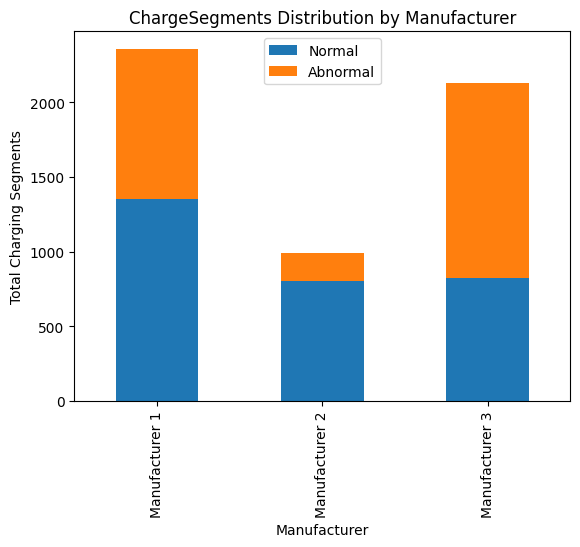

In [14]:
NormalSamples = [ev1_df[ev1_df['Label']==0]['ChargeSegment'].unique().size, 
              ev2_df[ev2_df['Label']==0]['ChargeSegment'].unique().size, 
              ev3_df[ev3_df['Label']==0]['ChargeSegment'].unique().size]
AbnormalSamples = [ev1_df[ev1_df['Label']!=0]['ChargeSegment'].unique().size,
                ev2_df[ev2_df['Label']!=0]['ChargeSegment'].unique().size, 
                ev3_df[ev3_df['Label']!=0]['ChargeSegment'].unique().size]
samples_df = pd.DataFrame({'Normal': NormalSamples, 'Abnormal':AbnormalSamples}, index=labels)
samples_df.plot(kind='bar', stacked=True)
plt.title('ChargeSegments Distribution by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Total Charging Segments')
plt.show()
del NormalSamples, AbnormalSamples, samples_df

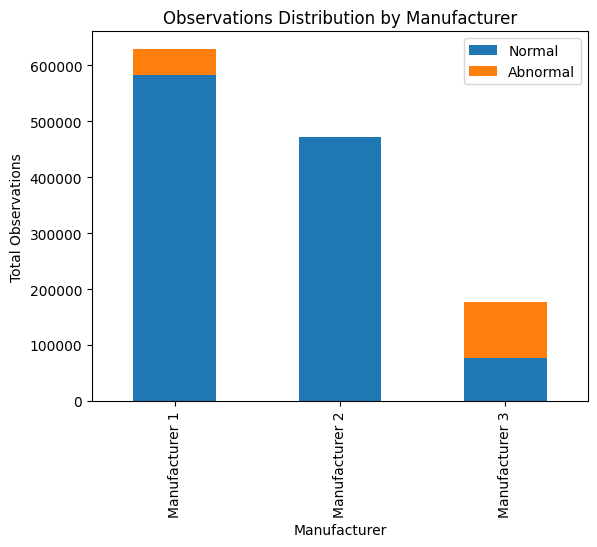

In [15]:
NormalSamples = [ev1_df[ev1_df['Label']==0].shape[0], 
              ev2_df[ev2_df['Label']==0].shape[0], 
              ev3_df[ev3_df['Label']==0].shape[0]]
AbnormalSamples = [ev1_df[ev1_df['Label']!=0].shape[0],
                ev2_df[ev2_df['Label']!=0].shape[0], 
                ev3_df[ev3_df['Label']!=0].shape[0]]
samples_df = pd.DataFrame({'Normal': NormalSamples, 'Abnormal':AbnormalSamples}, index=labels)
samples_df.plot(kind='bar', stacked=True)
plt.title('Observations Distribution by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Total Observations')
plt.show()
del NormalSamples, AbnormalSamples

In [16]:
samples_df

,Normal,Abnormal
Manufacturer 1,582623,46498
Manufacturer 2,472193,636
Manufacturer 3,77276,99051


In [17]:
ev3_df.groupby('Car')['ChargeSegment'].count()

Car
500    16282
501    16025
502    10724
503     7436
504     1754
505      468
506     9439
507     4582
508     4862
509      554
510    16152
511     3937
512     9077
513      270
514      794
515     2402
516     7130
517     1267
518     1640
519      793
520     4170
521    15349
522      157
523     6416
524     5013
525      497
526      261
527     5643
528     1740
529     2237
530      585
531      463
532     2273
533     1013
534     1847
535      449
536      527
537     1941
538     2324
539      965
540     2023
541     3079
542      356
543      240
544      315
546       27
547       28
548      117
549      684
Name: ChargeSegment, dtype: int64

In [18]:
del samples_df, labels

### Observe Data Correlation

#### Check for Null, Infinity or Zero values

In [19]:
np.isnan(ev3_df).sum()

Label            0
Car              0
ChargeSegment    0
Mileage          0
Capacity         0
V1               0
V2               0
V3               0
V4               0
V5               0
V6               0
V7               0
V8               0
ExpVar           0
dtype: int64

In [20]:
np.isinf(ev3_df).sum()

Label            0
Car              0
ChargeSegment    0
Mileage          0
Capacity         0
V1               0
V2               0
V3               0
V4               0
V5               0
V6               0
V7               0
V8               0
ExpVar           0
dtype: int64

In [21]:
(ev3_df == 0).sum()

Label            77276
Car                  0
ChargeSegment     2522
Mileage              0
Capacity             0
V1                   0
V2                   0
V3                   0
V4                   0
V5                   0
V6                   0
V7                   0
V8                   0
ExpVar               0
dtype: int64

#### Create Pairplot to understand the relations

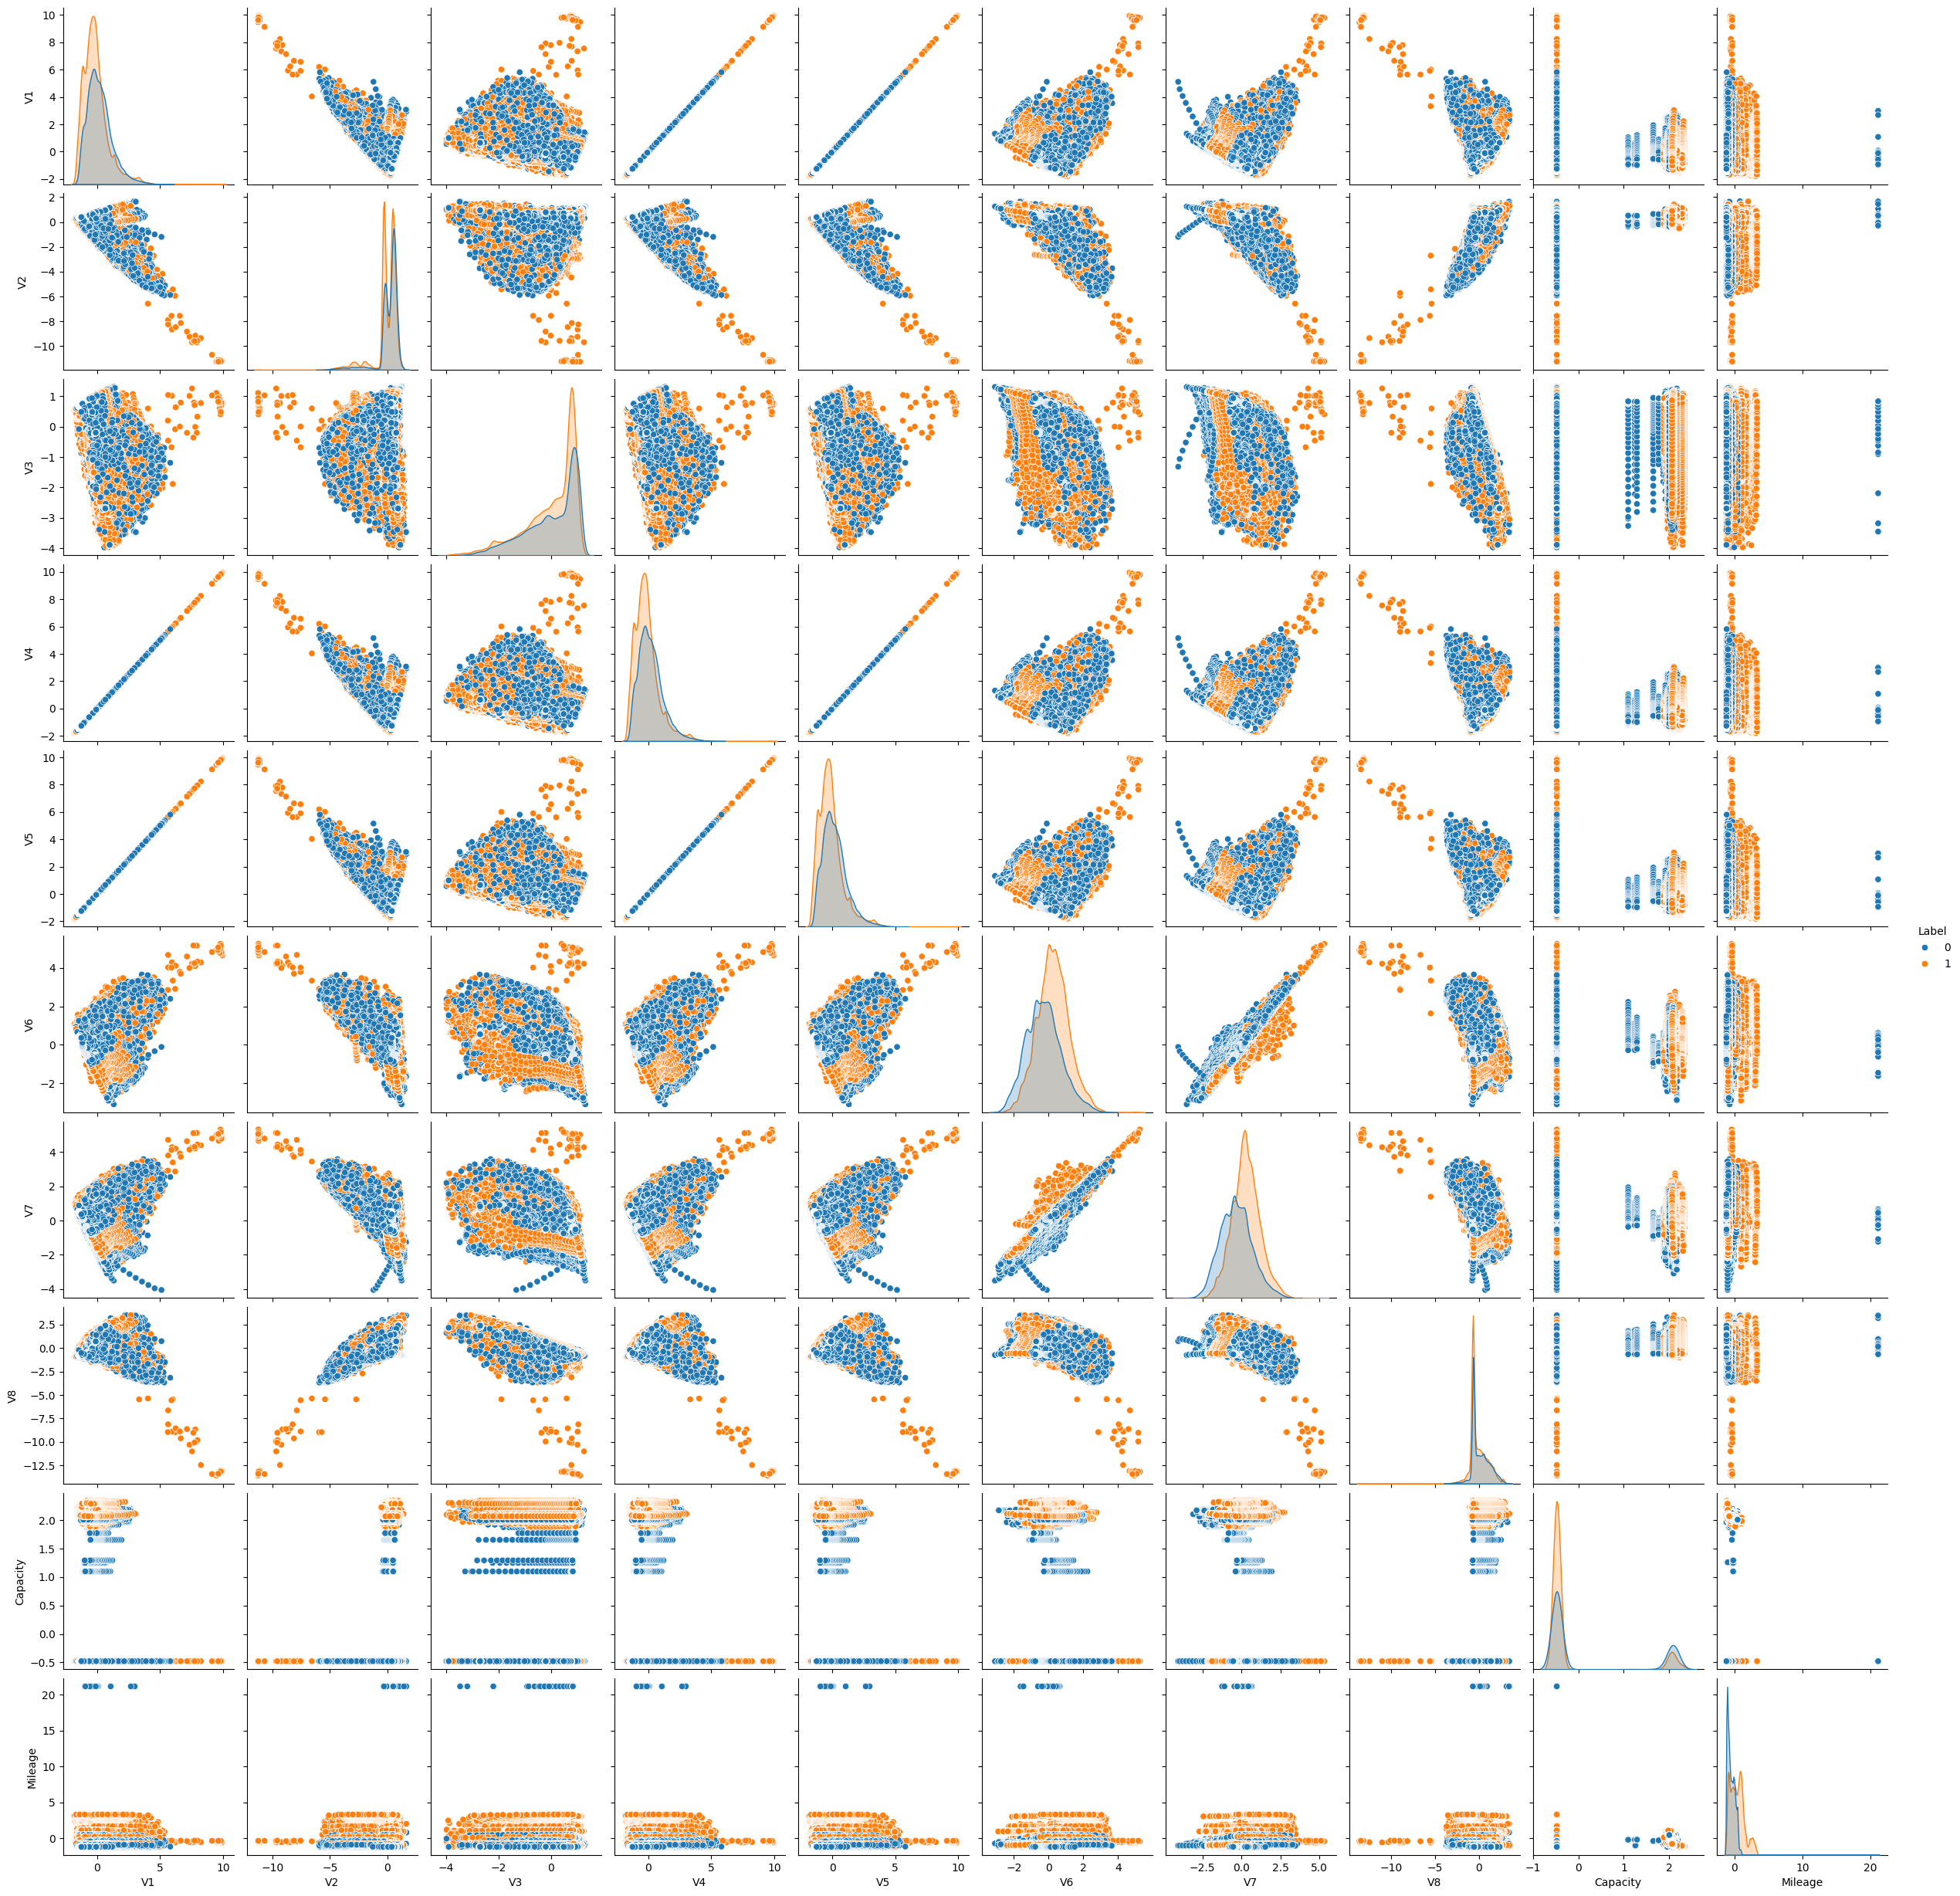

In [22]:
# Plot the pairplot of each manufacturer dataset to visualize the clustering of data points based on the label
# Using Manufacturer 3 dataset as an example
sns.pairplot(ev3_df[['Label','V1','V2','V3','V4','V5','V6','V7','V8','Capacity','Mileage']], hue='Label')

#### Pearson Correlation

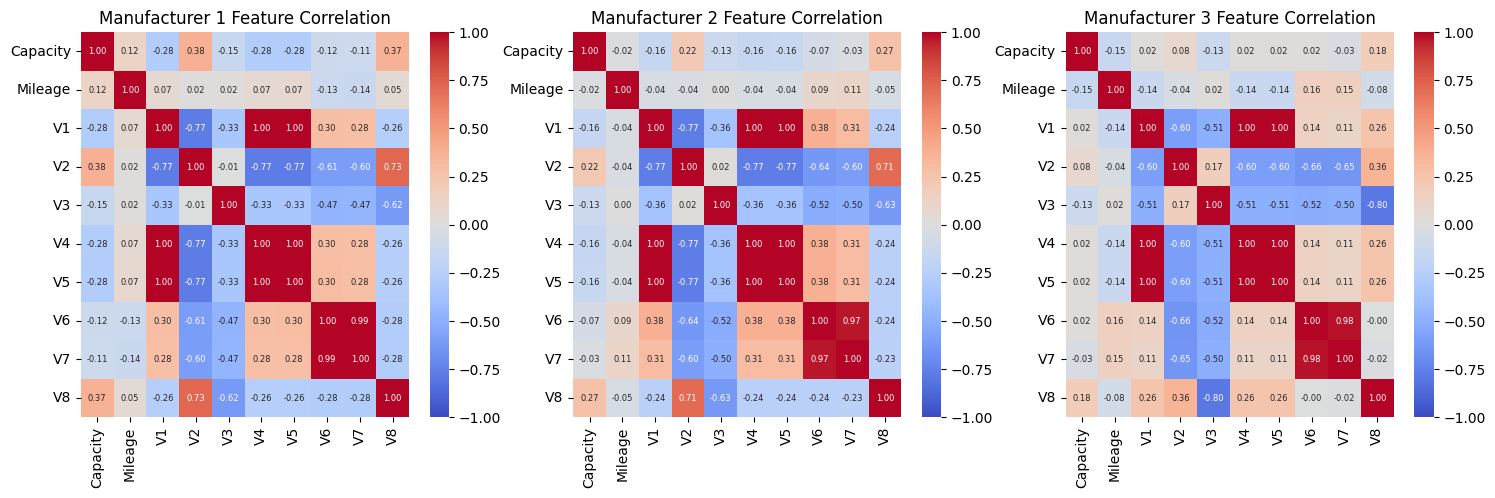

In [23]:
# Observe the pearson correlation between features in different manufacturer datasets
ev1_pearson = ev1_df[['Capacity','Mileage','V1','V2','V3','V4','V5','V6','V7','V8']].corr(method='pearson')
ev2_pearson = ev2_df[['Capacity','Mileage','V1','V2','V3','V4','V5','V6','V7','V8']].corr(method='pearson')
ev3_pearson = ev3_df[['Capacity','Mileage','V1','V2','V3','V4','V5','V6','V7','V8']].corr(method='pearson')
# Plot heatmaps for each manufacturer dataset
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.heatmap(ev1_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', annot_kws={"size": 6})
plt.title('Manufacturer 1 Feature Correlation')
plt.subplot(1, 3, 2)
sns.heatmap(ev2_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', annot_kws={"size": 6})
plt.title('Manufacturer 2 Feature Correlation')
plt.subplot(1, 3, 3)
sns.heatmap(ev3_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', annot_kws={"size": 6})
plt.title('Manufacturer 3 Feature Correlation')
plt.show()
del ev1_pearson, ev2_pearson, ev3_pearson

#### Spearman Correlation

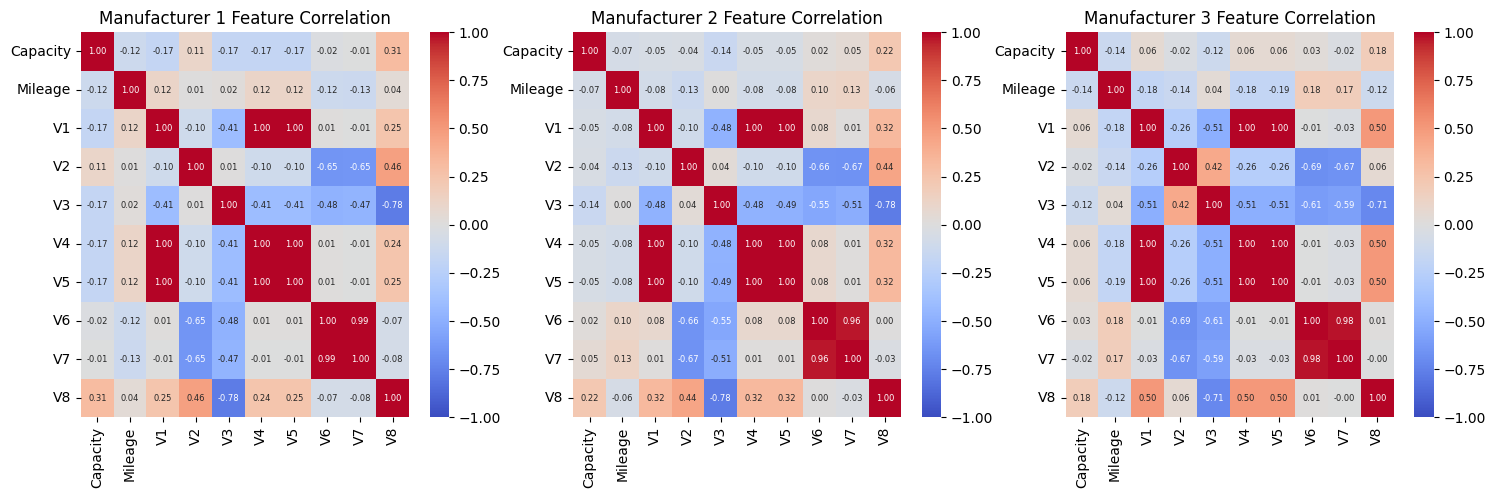

In [24]:
# Observe the spearman correlation between features in different manufacturer datasets
ev1_spearman = ev1_df[['Capacity','Mileage','V1','V2','V3','V4','V5','V6','V7','V8']].corr(method='spearman')
ev2_spearman = ev2_df[['Capacity','Mileage','V1','V2','V3','V4','V5','V6','V7','V8']].corr(method='spearman')
ev3_spearman = ev3_df[['Capacity','Mileage','V1','V2','V3','V4','V5','V6','V7','V8']].corr(method='spearman')
# Plot heatmaps for each manufacturer dataset
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.heatmap(ev1_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', annot_kws={"size": 6})
plt.title('Manufacturer 1 Feature Correlation')
plt.subplot(1, 3, 2)
sns.heatmap(ev2_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', annot_kws={"size": 6})
plt.title('Manufacturer 2 Feature Correlation')
plt.subplot(1, 3, 3)
sns.heatmap(ev3_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', annot_kws={"size": 6})
plt.title('Manufacturer 3 Feature Correlation')
plt.show()
del ev1_spearman, ev2_spearman, ev3_spearman

## Data Preparation for Modelling

In [25]:
# Based on the correlation heatmaps, we can see that V4, V5 are highly correlated to V1 and with each other (hence we can drop one of them)
# We can also see that V6 & V7 are highly correlated with each other (hence we can drop one of them)
# We can also see that Mileage and Capacity are not highly correlated with any of the V1 to V8 features.
# Also V3 & V8 also has strong correlation (0.78)
# Hence, we can drop Mileage and Capacity from the datasets for further analysis

# Perform Modeling Logistic Regression, Random Forest, XGBoost, Neural Networks etc.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Drop Label and other index features that are not required for modeling
X_train, X_test, y_train, y_test = train_test_split(ev3_df.drop(columns=['Label','Car','ChargeSegment','ExpVar']), 
                                                    ev3_df['Label'], test_size=0.2, random_state=42, 
                                                    stratify=ev3_df['Label'])
# Drop correlated features V4, V5, V6
X_train_nocorr, X_test_nocorr, y_train_nocorr, y_test_nocorr = train_test_split(ev3_df.drop(
                                                                                    columns=['Label','Car','ChargeSegment','ExpVar','V4','V5','V6']), 
                                                                                ev3_df['Label'], test_size=0.2, random_state=42, 
                                                                                stratify=ev3_df['Label'])
# Drop Mileage and Capacity
X_nocapmile = ev3_df.drop(columns=['Label','Car','ChargeSegment','Mileage','Capacity','V4','V5','V6'])
X_train_nocapmile, X_test_nocapmile, y_train_nocapmile, y_test_nocapmile = train_test_split(ev3_df.drop(
                                                                                        columns=['Label','Car','ChargeSegment','Mileage',
                                                                                             'Capacity','ExpVar','V4','V5','V6']), 
                                                                                    ev3_df['Label'], test_size=0.2, random_state=42, 
                                                                                    stratify=ev3_df['Label'])
# Initialize Manufacturer 1 and 2 datasets for model generalization
mf1_x = ev1_df.drop(columns=['Label','Car','ChargeSegment','ExpVar','V4','V5','V6'])
mf1_y = ev1_df['Label']
mf2_x = ev2_df.drop(columns=['Label','Car','ChargeSegment','ExpVar','V4','V5','V6'])
mf2_y = ev2_df['Label']
mf1_x_nocapmile = ev1_df.drop(columns=['Label','Car','ChargeSegment','Mileage','Capacity','ExpVar','V4','V5','V6'])
mf2_x_nocapmile = ev2_df.drop(columns=['Label','Car','ChargeSegment','Mileage','Capacity','ExpVar','V4','V5','V6'])

## Modelling

### Logistic Regression

In [26]:
# Print Model Results
def model_results(model, X_test, y_test):
    y_pred = model.predict(X_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    model_classification_report = classification_report(y_test, y_pred)
    model_confusion_matrix = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {model_accuracy:.4f}")
    print("Classification Report:")
    print(model_classification_report)
    print("Confusion Matrix:")
    print(model_confusion_matrix)
    del y_pred
    return model_accuracy, model_classification_report, model_confusion_matrix

#### With all variables

In [27]:
# Perform Logistic Regression on Manufacturer 3 Dataset
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
# Print Model Test Results
print("Logistic Regression Model Results on Manufacturer 3 Dataset:")
model_accuracy, model_classification_report, model_confusion_matrix = model_results(model, X_test, y_test)
print("Important Features:")
print(np.abs(model.coef_[0]))

Logistic Regression Model Results on Manufacturer 3 Dataset:
Accuracy: 0.7743
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.74     15455
           1       0.79      0.81      0.80     19811

    accuracy                           0.77     35266
   macro avg       0.77      0.77      0.77     35266
weighted avg       0.77      0.77      0.77     35266

Confusion Matrix:
[[11180  4275]
 [ 3683 16128]]
Important Features:
[ 1.16868688  0.16681578  0.9070093   0.06737305  0.11772742 38.65291701
 39.9412548   2.52304061  3.09387923  0.06937841]


#### Feature Importance - SHAP

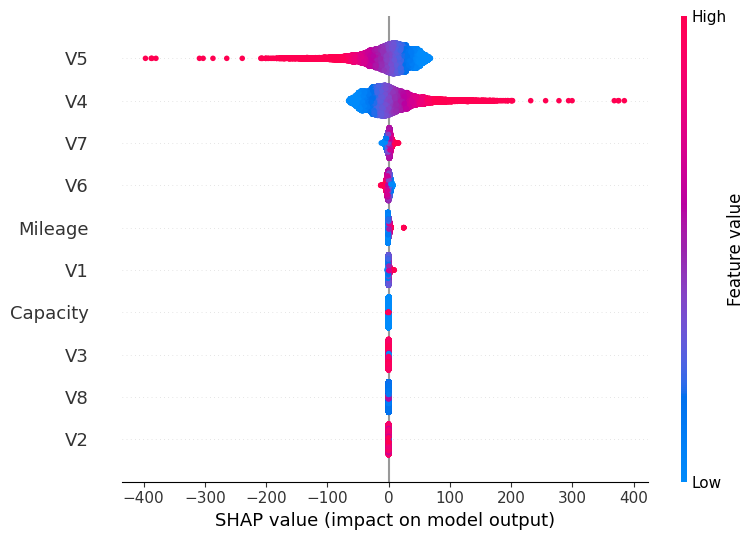

In [28]:
# Understand feature importance using SHAP and LIME
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

#### Feature Importance - Permutation

In [29]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
importance = result.importances_mean
print("Feature importance (Permutation):", importance)

Feature importance (Permutation): [1.16310327e-01 2.56337549e-03 4.97192764e-02 2.60874497e-04
 2.68247037e-03 2.12692111e-01 3.20342540e-01 1.06981228e-01
 2.57874440e-01 4.36681223e-04]


#### Dropping Correlated features V4,V5,V6

In [30]:
# Perform Logistic Regression on Manufacturer 3 Dataset by dropping correlated features V4, V5, V6
model_nocorr = LogisticRegression(max_iter=10000)
model_nocorr.fit(X_train_nocorr, y_train_nocorr)
# Print Model Test Results
print("Logistic Regression Model Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6:")
model_nocorr_accuracy, model_nocorr_classification_report, model_nocorr_confusion_matrix = model_results(model_nocorr, X_test_nocorr, y_test_nocorr)
print("Important Features:")
print(np.abs(model_nocorr.coef_[0]))

Logistic Regression Model Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6:
Accuracy: 0.7571
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72     15455
           1       0.77      0.81      0.79     19811

    accuracy                           0.76     35266
   macro avg       0.75      0.75      0.75     35266
weighted avg       0.76      0.76      0.76     35266

Confusion Matrix:
[[10750  4705]
 [ 3861 15950]]
Important Features:
[1.39893982 0.19442462 4.12844269 4.55022536 5.39595445 5.89320637
 1.55072655]


##### Feature Importance - SHAP

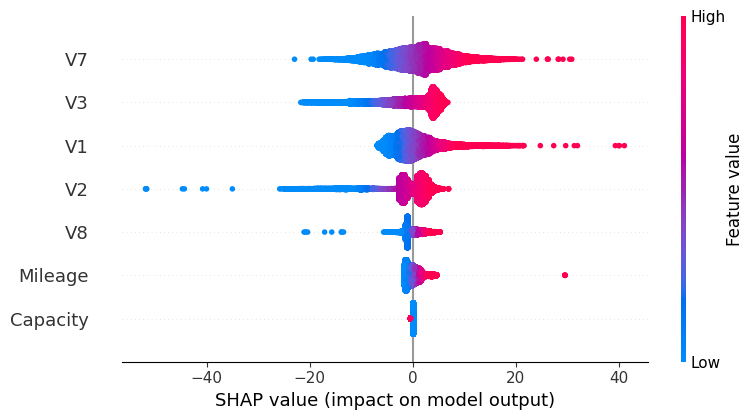

In [31]:
explainer = shap.Explainer(model_nocorr, X_train_nocorr)
shap_values = explainer(X_test_nocorr)
shap.summary_plot(shap_values, X_test_nocorr)

##### Validate against other Manufacturer's Dataset

In [32]:
# Observe the model generalization on Manufacturer 1 and 2 datasets
print("Manufacturer 1 Data Set Results with Logistic Regression Model without Correlated Features")
mf1lr_nocorr_accuracy, mf1lr_nocorr_classification_report, mf1lr_nocorr_confusion_matrix = model_results(model_nocorr, mf1_x, mf1_y)
print("Manufacturer 2 Data Set Results with Logistic Regression Model without Correlated Features")
mf2lr_nocorr_accuracy, mf2lr_nocorr_classification_report, mf2lr_nocorr_confusion_matrix = model_results(model_nocorr, mf2_x, mf2_y)

Manufacturer 1 Data Set Results with Logistic Regression Model without Correlated Features
Accuracy: 0.3972
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.40      0.55    582623
           1       0.05      0.40      0.09     46498

    accuracy                           0.40    629121
   macro avg       0.47      0.40      0.32    629121
weighted avg       0.83      0.40      0.52    629121

Confusion Matrix:
[[231384 351239]
 [ 27972  18526]]
Manufacturer 2 Data Set Results with Logistic Regression Model without Correlated Features
Accuracy: 0.3879
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.39      0.56    472193
           1       0.00      0.77      0.00       636

    accuracy                           0.39    472829
   macro avg       0.50      0.58      0.28    472829
weighted avg       1.00      0.39      0.56    472829

Confusion Matrix:
[[182944 2892

#### Dropping Mileage & Capacity 

In [33]:
# Perform Logistic Regression on Manufacturer 3 Dataset by dropping correlated features V4, V5, V7 and Mileage, Capacity
model_nocapmile = LogisticRegression(max_iter=10000)
model_nocapmile.fit(X_train_nocapmile, y_train_nocapmile)
# Print Model Test Results
print("Logistic Regression Model Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6 and Mileage, Capacity:")
model_nocapmile_accuracy, model_nocapmile_classification_report, model_nocapmile_confusion_matrix = model_results(model_nocapmile, X_test_nocapmile, y_test_nocapmile)
print("Important Features:")
print(np.abs(model_nocapmile.coef_[0]))

Logistic Regression Model Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6 and Mileage, Capacity:
Accuracy: 0.6722
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57     15455
           1       0.68      0.80      0.73     19811

    accuracy                           0.67     35266
   macro avg       0.67      0.65      0.65     35266
weighted avg       0.67      0.67      0.66     35266

Confusion Matrix:
[[ 7804  7651]
 [ 3909 15902]]
Important Features:
[2.54469422 3.00251658 3.67516814 4.2167924  1.01636821]


##### Validate against other Manufacturer's Dataset

In [34]:
# Observe the model generalization on Manufacturer 1 and 2 datasets
print("Manufacturer 1 Data Set Results with Logistic Regression Model without Mileage and Capacity")
mf1lr_nocapmile_accuracy, mf1lr_nocapmile_classification_report, mf1lr_nocapmile_confusion_matrix = model_results(model_nocapmile, mf1_x_nocapmile, mf1_y)
print("Manufacturer 2 Data Set Results with Logistic Regression Model without Mileage and Capacity")
mf2lr_nocapmile_accuracy, mf2lr_nocapmile_classification_report, mf2lr_nocapmile_confusion_matrix = model_results(model_nocapmile, mf2_x_nocapmile, mf2_y)

Manufacturer 1 Data Set Results with Logistic Regression Model without Mileage and Capacity
Accuracy: 0.4393
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.43      0.59    582623
           1       0.08      0.58      0.13     46498

    accuracy                           0.44    629121
   macro avg       0.50      0.50      0.36    629121
weighted avg       0.86      0.44      0.55    629121

Confusion Matrix:
[[249322 333301]
 [ 19455  27043]]
Manufacturer 2 Data Set Results with Logistic Regression Model without Mileage and Capacity
Accuracy: 0.4071
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.41      0.58    472193
           1       0.00      0.53      0.00       636

    accuracy                           0.41    472829
   macro avg       0.50      0.47      0.29    472829
weighted avg       1.00      0.41      0.58    472829

Confusion Matrix:
[[192157 28

### Support Vector Classifier

#### With V1,V2,V3,V7,V8,Mileage,Capacity

In [35]:
# Model with Support Vector Machine using Manufacturer 3 dataset
from sklearn.svm import SVC
model_svc = SVC()
model_svc.fit(X_train_nocorr, y_train_nocorr)
# Print Model Test Results
print("Support Vector Classifier Model Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6:")
svc_accuracy, svc_classification_report, svc_confusion_matrix = model_results(model_svc, X_test_nocorr, y_test_nocorr)


Support Vector Classifier Model Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6:
Accuracy: 0.8239
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79     15455
           1       0.81      0.89      0.85     19811

    accuracy                           0.82     35266
   macro avg       0.83      0.81      0.82     35266
weighted avg       0.83      0.82      0.82     35266

Confusion Matrix:
[[11428  4027]
 [ 2182 17629]]


#### Without Mileage & Capacity

In [36]:
# Model with Support Vector Machine using Manufacturer 3 dataset without Mileage and Capacity
model_svc_nocapmile = SVC()
model_svc_nocapmile.fit(X_train_nocapmile, y_train_nocapmile)
# Print Model Test Results
print("Support Vector Classifier Model Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6 and Mileage, Capacity:")
svc_nocapmile_accuracy, svc_nocapmile_classification_report, svc_nocapmile_confusion_matrix = model_results(model_svc_nocapmile, X_test_nocapmile, y_test_nocapmile)

Support Vector Classifier Model Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6 and Mileage, Capacity:
Accuracy: 0.7012
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.53      0.61     15455
           1       0.70      0.83      0.76     19811

    accuracy                           0.70     35266
   macro avg       0.70      0.68      0.68     35266
weighted avg       0.70      0.70      0.69     35266

Confusion Matrix:
[[ 8244  7211]
 [ 3325 16486]]


#### Validate against other Manufacturer's Data

In [37]:
# SVM model with Manufacturer 1 and 2 datasets
print("Manufacturer 1 Data Set Results with SVC Model without V4, V5, V6")
mf1_svc_accuracy, mf1_svc_classification_report, mf1_svc_confusion_matrix = model_results(model_svc, mf1_x, mf1_y)
print("Manufacturer 2 Data Set Results with SVC Model without V4, V5, V6")
mf2_svc_accuracy, mf2_svc_classification_report, mf2_svc_confusion_matrix = model_results(model_svc, mf2_x, mf2_y)

Manufacturer 1 Data Set Results with SVC Model without V4, V5, V6
Accuracy: 0.4646
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.46      0.61    582623
           1       0.07      0.53      0.13     46498

    accuracy                           0.46    629121
   macro avg       0.50      0.50      0.37    629121
weighted avg       0.86      0.46      0.58    629121

Confusion Matrix:
[[267458 315165]
 [ 21643  24855]]
Manufacturer 2 Data Set Results with SVC Model without V4, V5, V6
Accuracy: 0.3981
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57    472193
           1       0.00      0.85      0.00       636

    accuracy                           0.40    472829
   macro avg       0.50      0.62      0.29    472829
weighted avg       1.00      0.40      0.57    472829

Confusion Matrix:
[[187691 284502]
 [    97    539]]


In [38]:
# SVM model with Manufacturer 1 and 2 datasets
print("Manufacturer 1 Data Set Results with SVC Model without Mileage and Capacity")
mf1_svc_nocapmile_accuracy, mf1_svc_nocapmile_classification_report, mf1_svc_nocapmile_confusion_matrix = model_results(model_svc_nocapmile, mf1_x_nocapmile, mf1_y)
print("Manufacturer 2 Data Set Results with SVC Model without Mileage and Capacity")
mf2_svc_nocapmile_accuracy, mf2_svc_nocapmile_classification_report, mf2_svc_nocapmile_confusion_matrix = model_results(model_svc_nocapmile, mf2_x_nocapmile, mf2_y)

Manufacturer 1 Data Set Results with SVC Model without Mileage and Capacity
Accuracy: 0.5340
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.54      0.68    582623
           1       0.08      0.49      0.13     46498

    accuracy                           0.53    629121
   macro avg       0.50      0.51      0.41    629121
weighted avg       0.87      0.53      0.64    629121

Confusion Matrix:
[[313309 269314]
 [ 23830  22668]]
Manufacturer 2 Data Set Results with SVC Model without Mileage and Capacity
Accuracy: 0.5041
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67    472193
           1       0.00      0.64      0.00       636

    accuracy                           0.50    472829
   macro avg       0.50      0.57      0.34    472829
weighted avg       1.00      0.50      0.67    472829

Confusion Matrix:
[[237935 234258]
 [   226    410]]


### Random Forest Classifier

#### With V1,V2,V3,V7,V8,Mileage,Capacity

In [39]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_nocorr, y_train_nocorr)
# Print Model Test Results
print("Random Forest Classifier Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6:")
rf_accuracy, rf_classification_report, rf_confusion_matrix = model_results(model_rf, X_test_nocorr, y_test_nocorr)

Random Forest Classifier Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6:
Accuracy: 0.9518
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     15455
           1       0.95      0.96      0.96     19811

    accuracy                           0.95     35266
   macro avg       0.95      0.95      0.95     35266
weighted avg       0.95      0.95      0.95     35266

Confusion Matrix:
[[14458   997]
 [  703 19108]]


In [40]:
model_rf.feature_importances_

array([0.42280468, 0.06725494, 0.0958008 , 0.12270166, 0.06997168,
       0.13738234, 0.0840839 ])

#### Without Mileage and Capacity

In [41]:
# Random Forest Classifier without Mileage and Capacity
from sklearn.ensemble import RandomForestClassifier
model_rf_nocapmile = RandomForestClassifier()
model_rf_nocapmile.fit(X_train_nocapmile, y_train_nocapmile)
# Print Model Test Results
print("Random Forest Classifier Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6, Mileage, Capacity:")
rf_nocapmile_accuracy, rf_nocapmile_classification_report, rf_nocapmile_confusion_matrix = model_results(model_rf_nocapmile, X_test_nocapmile, y_test_nocapmile)

Random Forest Classifier Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6, Mileage, Capacity:
Accuracy: 0.8412
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81     15455
           1       0.84      0.88      0.86     19811

    accuracy                           0.84     35266
   macro avg       0.84      0.84      0.84     35266
weighted avg       0.84      0.84      0.84     35266

Confusion Matrix:
[[12230  3225]
 [ 2374 17437]]


In [42]:
model_rf_nocapmile.feature_importances_

array([0.20386626, 0.22953267, 0.157478  , 0.22970987, 0.1794132 ])

#### Validate against other Manufacturer's data

In [43]:
# On Manufacturer 1 and 2 datasets
print("Manufacturer 1 Data Set Results with Random Forest Classifier without Mileage and Capacity")
mf1_rf_accuracy, mf1_rf_classification_report, mf1_rf_confusion_matrix = model_results(model_rf, mf1_x, mf1_y)
print("Manufacturer 2 Data Set Results with Random Forest Classifier without Mileage and Capacity")
mf2_rf_accuracy, mf2_rf_classification_report, mf2_rf_confusion_matrix = model_results(model_rf, mf2_x, mf2_y)

Manufacturer 1 Data Set Results with Random Forest Classifier without Mileage and Capacity
Accuracy: 0.4260
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.43      0.58    582623
           1       0.04      0.32      0.08     46498

    accuracy                           0.43    629121
   macro avg       0.47      0.38      0.33    629121
weighted avg       0.83      0.43      0.55    629121

Confusion Matrix:
[[252961 329662]
 [ 31481  15017]]
Manufacturer 2 Data Set Results with Random Forest Classifier without Mileage and Capacity
Accuracy: 0.4255
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.42      0.60    472193
           1       0.00      0.84      0.00       636

    accuracy                           0.43    472829
   macro avg       0.50      0.63      0.30    472829
weighted avg       1.00      0.43      0.60    472829

Confusion Matrix:
[[200644 2715

In [44]:
# On Manufacturer 1 and 2 datasets
print("Manufacturer 1 Data Set Results with Random Forest Classifier without Mileage and Capacity")
mf1_rf_nocapmile_accuracy, mf1_rf_nocapmile_classification_report, mf1_rf_nocapmile_confusion_matrix = model_results(model_rf_nocapmile, mf1_x_nocapmile, mf1_y)
print("Manufacturer 2 Data Set Results with Random Forest Classifier without Mileage and Capacity")
mf2_rf_nocapmile_accuracy, mf2_rf_nocapmile_classification_report, mf2_rf_nocapmile_confusion_matrix = model_results(model_rf_nocapmile, mf2_x_nocapmile, mf2_y)

Manufacturer 1 Data Set Results with Random Forest Classifier without Mileage and Capacity
Accuracy: 0.6181
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.63      0.75    582623
           1       0.09      0.43      0.14     46498

    accuracy                           0.62    629121
   macro avg       0.51      0.53      0.45    629121
weighted avg       0.87      0.62      0.71    629121

Confusion Matrix:
[[368784 213839]
 [ 26398  20100]]
Manufacturer 2 Data Set Results with Random Forest Classifier without Mileage and Capacity
Accuracy: 0.4715
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.47      0.64    472193
           1       0.00      0.44      0.00       636

    accuracy                           0.47    472829
   macro avg       0.50      0.46      0.32    472829
weighted avg       1.00      0.47      0.64    472829

Confusion Matrix:
[[222652 2495

### XGBoost Classifier

#### With V1,V2,V3,V7,V8,Mileage,Capacity

In [45]:
#XGBoost Classifier
import xgboost as xgb
from xgboost import XGBClassifier
model_xgb = XGBClassifier(eval_metric='mlogloss')
model_xgb.fit(X_train_nocorr, y_train_nocorr)
# Print Model Test Results
print("XGBoost Classifier Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6:")
xgb_accuracy, xgb_classification_report, xgb_confusion_matrix = model_results(model_xgb, X_test_nocorr, y_test_nocorr)

XGBoost Classifier Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6:
Accuracy: 0.9205
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     15455
           1       0.91      0.95      0.93     19811

    accuracy                           0.92     35266
   macro avg       0.92      0.92      0.92     35266
weighted avg       0.92      0.92      0.92     35266

Confusion Matrix:
[[13710  1745]
 [ 1058 18753]]


#### Without Mileage and Capacity

In [46]:
# Without Mileage and Capacity
model_xgb_nocapmile = XGBClassifier(eval_metric='mlogloss')
model_xgb_nocapmile.fit(X_train_nocapmile, y_train_nocapmile)
# Print Model Test Results
print("XGBoost Classifier Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6 and Mileage, Capacity:")
xgb_nocapmile_accuracy, xgb_nocapmile_classification_report, xgb_nocapmile_confusion_matrix = model_results(model_xgb_nocapmile, X_test_nocapmile, y_test_nocapmile)

XGBoost Classifier Results on Manufacturer 3 Dataset after dropping correlated features V4, V5, V6 and Mileage, Capacity:
Accuracy: 0.7771
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73     15455
           1       0.77      0.86      0.81     19811

    accuracy                           0.78     35266
   macro avg       0.78      0.77      0.77     35266
weighted avg       0.78      0.78      0.77     35266

Confusion Matrix:
[[10370  5085]
 [ 2776 17035]]


#### Validate other Manufacturer's Data

In [47]:
# For Manufacturer 1 and 2 datasets
print("Manufacturer 1 Data Set Results with XGBoost Classifier without Mileage and Capacity")
mf1_xgb_accuracy, mf1_xgb_classification_report, mf1_xgb_confusion_matrix = model_results(model_xgb, mf1_x, mf1_y)
print("Manufacturer 2 Data Set Results with XGBoost Classifier without Mileage and Capacity")
mf2_xgb_accuracy, mf2_xgb_classification_report, mf2_xgb_confusion_matrix = model_results(model_xgb, mf2_x, mf2_y)

Manufacturer 1 Data Set Results with XGBoost Classifier without Mileage and Capacity
Accuracy: 0.4014
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.41      0.56    582623
           1       0.04      0.30      0.07     46498

    accuracy                           0.40    629121
   macro avg       0.46      0.36      0.31    629121
weighted avg       0.82      0.40      0.52    629121

Confusion Matrix:
[[238414 344209]
 [ 32360  14138]]
Manufacturer 2 Data Set Results with XGBoost Classifier without Mileage and Capacity
Accuracy: 0.4106
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.41      0.58    472193
           1       0.00      0.85      0.00       636

    accuracy                           0.41    472829
   macro avg       0.50      0.63      0.29    472829
weighted avg       1.00      0.41      0.58    472829

Confusion Matrix:
[[193587 278606]
 [    96

In [48]:
# For Manufacturer 1 and 2 datasets
print("Manufacturer 1 Data Set Results with XGBoost Classifier without Mileage and Capacity")
mf1_xgb_nocapmile_accuracy, mf1_xgb_nocapmile_classification_report, mf1_xgb_nocapmile_confusion_matrix = model_results(model_xgb_nocapmile, mf1_x_nocapmile, mf1_y)
print("Manufacturer 2 Data Set Results with XGBoost Classifier without Mileage and Capacity")
mf2_xgb_nocapmile_accuracy, mf2_xgb_nocapmile_classification_report, mf2_xgb_nocapmile_confusion_matrix = model_results(model_xgb_nocapmile, mf2_x_nocapmile, mf2_y)

Manufacturer 1 Data Set Results with XGBoost Classifier without Mileage and Capacity
Accuracy: 0.6203
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.63      0.76    582623
           1       0.09      0.45      0.15     46498

    accuracy                           0.62    629121
   macro avg       0.51      0.54      0.45    629121
weighted avg       0.87      0.62      0.71    629121

Confusion Matrix:
[[369452 213171]
 [ 25679  20819]]
Manufacturer 2 Data Set Results with XGBoost Classifier without Mileage and Capacity
Accuracy: 0.4327
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60    472193
           1       0.00      0.46      0.00       636

    accuracy                           0.43    472829
   macro avg       0.50      0.45      0.30    472829
weighted avg       1.00      0.43      0.60    472829

Confusion Matrix:
[[204281 267912]
 [   341

### CNN

#### Load Libraries

In [57]:
# CNN Model using Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical


In [58]:
# Test TensorFlow installation
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.20.0
Keras version: 3.11.3
Num GPUs Available:  0


In [59]:
# Print Model Results
def dl_model_results(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    model_accuracy = accuracy_score(y_test, y_pred)
    model_classification_report = classification_report(y_test, y_pred)
    model_confusion_matrix = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {model_accuracy:.4f}")
    print("Classification Report:")
    print(model_classification_report)
    print("Confusion Matrix:")
    print(model_confusion_matrix)
    del y_pred
    return model_accuracy, model_classification_report, model_confusion_matrix

#### Prepare Data

In [52]:
# Prepare data for Deep Learning models
X_train_nocorr_dl = X_train_nocorr.values.reshape(-1, X_train_nocorr.shape[1], 1)
print(X_train_nocorr_dl.shape)
X_test_nocorr_dl = X_test_nocorr.values.reshape(-1, X_test_nocorr.shape[1], 1)
print(X_test_nocorr_dl.shape)
X_train_nocapmile_dl = X_train_nocapmile.values.reshape(-1, X_train_nocapmile.shape[1], 1)
print(X_train_nocapmile_dl.shape)
X_test_nocapmile_dl = X_test_nocapmile.values.reshape(-1, X_test_nocapmile.shape[1], 1)
print(X_test_nocapmile_dl.shape)
mf1_x_dl = mf1_x.values.reshape(-1, mf1_x.shape[1], 1)
mf2_x_dl = mf2_x.values.reshape(-1, mf2_x.shape[1], 1)
mf1_x_nocapmile_dl = mf1_x_nocapmile.values.reshape(-1, mf1_x_nocapmile.shape[1], 1)
mf2_x_nocapmile_dl = mf2_x_nocapmile.values.reshape(-1, mf2_x_nocapmile.shape[1], 1)

(141061, 7, 1)
(35266, 7, 1)
(141061, 5, 1)
(35266, 5, 1)


#### With V1,V2,V3,V7,V8,Mileage,Capacity

In [53]:
# Build the CNN model
model_cnn = keras.Sequential([
    layers.Conv1D(32, 2, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid') ])
# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
# Train the model
model_cnn.fit(X_train_nocorr_dl, y_train_nocorr, epochs=100, batch_size=32, validation_data=(X_test_nocorr_dl, y_test_nocorr))

Epoch 1/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 330us/step - accuracy: 0.8600 - loss: 0.3071 - val_accuracy: 0.8584 - val_loss: 0.3058
Epoch 2/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - accuracy: 0.8620 - loss: 0.3058 - val_accuracy: 0.8582 - val_loss: 0.3086
Epoch 3/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 327us/step - accuracy: 0.8606 - loss: 0.3061 - val_accuracy: 0.8545 - val_loss: 0.3140
Epoch 4/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step - accuracy: 0.8604 - loss: 0.3066 - val_accuracy: 0.8609 - val_loss: 0.3059
Epoch 5/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - accuracy: 0.8612 - loss: 0.3051 - val_accuracy: 0.8599 - val_loss: 0.3040
Epoch 6/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - accuracy: 0.8619 - loss: 0.3044 - val_accuracy: 0.8611 - val_loss: 0.3068
Epoch 7/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 324us/step - accuracy: 0.8616 - loss: 0.3040 - val_accuracy: 0.8617 - val_loss: 0.3022
Epoch 8/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 332us/step - accuracy: 

In [60]:
# Evaluate the model
print("Manufacturer 3 Dataset CNN Model Results after dropping correlated features V4, V5, V6:")
cnn_accuracy, cnn_classification_report, cnn_confusion_matrix = dl_model_results(model_cnn, X_test_nocorr_dl, y_test_nocorr)


Manufacturer 3 Dataset CNN Model Results after dropping correlated features V4, V5, V6:
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
Accuracy: 0.8702
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     15455
           1       0.87      0.90      0.89     19811

    accuracy                           0.87     35266
   macro avg       0.87      0.87      0.87     35266
weighted avg       0.87      0.87      0.87     35266

Confusion Matrix:
[[12857  2598]
 [ 1978 17833]]


#### Without Mileage and Capacity

In [61]:
# Build the CNN model
model_cnn_nocapmile = keras.Sequential([
    layers.Conv1D(32, 2, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid') ])
# Compile the model
model_cnn_nocapmile.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
# Train the model with Manufacturer 3 dataset without Mileage and Capacity
model_cnn_nocapmile.fit(X_train_nocapmile_dl, y_train_nocapmile, epochs=100, batch_size=32, validation_data=(X_test_nocapmile_dl, y_test_nocapmile))

Epoch 1/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 2s 347us/step - accuracy: 0.6808 - loss: 0.6010 - val_accuracy: 0.6842 - val_loss: 0.5934
Epoch 2/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 332us/step - accuracy: 0.6907 - loss: 0.5863 - val_accuracy: 0.6814 - val_loss: 0.5933
Epoch 3/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 332us/step - accuracy: 0.6947 - loss: 0.5795 - val_accuracy: 0.6930 - val_loss: 0.5773
Epoch 4/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step - accuracy: 0.6985 - loss: 0.5747 - val_accuracy: 0.6997 - val_loss: 0.5753
Epoch 5/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 332us/step - accuracy: 0.7016 - loss: 0.5711 - val_accuracy: 0.6995 - val_loss: 0.5706
Epoch 6/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step - accuracy: 0.7023 - loss: 0.5687 - val_accuracy: 0.6876 - val_loss: 0.5771
Epoch 7/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step - accuracy: 0.7053 - loss: 0.5665 - val_accuracy: 0.6976 - val_loss: 0.5717
Epoch 8/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - accuracy: 

In [63]:
# Evaluate the model
print("Manufacturer 3 Dataset CNN Model Results after dropping correlated features V4, V5, V6 and Mileage, Capacity:")
cnn_nocapmile_accuracy, cnn_nocapmile_classification_report, cnn_nocapmile_confusion_matrix = dl_model_results(model_cnn_nocapmile, X_test_nocapmile_dl, y_test_nocapmile)

Manufacturer 3 Dataset CNN Model Results after dropping correlated features V4, V5, V6 and Mileage, Capacity:
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 0s 168us/step
Accuracy: 0.7116
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66     15455
           1       0.74      0.76      0.75     19811

    accuracy                           0.71     35266
   macro avg       0.71      0.70      0.71     35266
weighted avg       0.71      0.71      0.71     35266

Confusion Matrix:
[[10026  5429]
 [ 4740 15071]]


#### Validate against other Manufacturer's Data

In [64]:
# For Manufacturer 1 and 2 datasets
print("Manufacturer 1 Data Set Results with CNN after dropping correlated features V4, V5, V6:")
mf1_cnn_accuracy, mf1_cnn_classification_report, mf1_cnn_confusion_matrix = dl_model_results(model_cnn, mf1_x_dl, mf1_y)
print("Manufacturer 2 Data Set Results with CNN after dropping correlated features V4, V5, V6:")
mf2_cnn_accuracy, mf2_cnn_classification_report, mf2_cnn_confusion_matrix = dl_model_results(model_cnn, mf2_x_dl, mf2_y)

Manufacturer 1 Data Set Results with CNN after dropping correlated features V4, V5, V6:
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 3s 154us/step
Accuracy: 0.5028
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.52      0.66    582623
           1       0.05      0.31      0.08     46498

    accuracy                           0.50    629121
   macro avg       0.48      0.41      0.37    629121
weighted avg       0.84      0.50      0.62    629121

Confusion Matrix:
[[301904 280719]
 [ 32081  14417]]
Manufacturer 2 Data Set Results with CNN after dropping correlated features V4, V5, V6:
14776/14776 ━━━━━━━━━━━━━━━━━━━━ 2s 155us/step
Accuracy: 0.5194
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68    472193
           1       0.00      0.52      0.00       636

    accuracy                           0.52    472829
   macro avg       0.50      0.52      0.34    47282

In [65]:
# For Manufacturer 1 and 2 datasets without Mileage and Capacity
print("Manufacturer 1 Data Set Results with CNN after dropping correlated features V4, V5, V6 and Mileage, Capacity:")
mf1_cnn_nocapmile_accuracy, mf1_cnn_nocapmile_classification_report, mf1_cnn_nocapmile_confusion_matrix = dl_model_results(model_cnn_nocapmile, mf1_x_nocapmile_dl, mf1_y)
print("Manufacturer 2 Data Set Results with CNN after dropping correlated features V4, V5, V6 and Mileage, Capacity:")
mf2_cnn_nocapmile_accuracy, mf2_cnn_nocapmile_classification_report, mf2_cnn_nocapmile_confusion_matrix = dl_model_results(model_cnn_nocapmile, mf2_x_nocapmile_dl, mf2_y)

Manufacturer 1 Data Set Results with CNN after dropping correlated features V4, V5, V6 and Mileage, Capacity:
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 3s 152us/step
Accuracy: 0.5319
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.53      0.68    582623
           1       0.09      0.55      0.15     46498

    accuracy                           0.53    629121
   macro avg       0.51      0.54      0.41    629121
weighted avg       0.87      0.53      0.64    629121

Confusion Matrix:
[[309144 273479]
 [ 21019  25479]]
Manufacturer 2 Data Set Results with CNN after dropping correlated features V4, V5, V6 and Mileage, Capacity:
14776/14776 ━━━━━━━━━━━━━━━━━━━━ 2s 150us/step
Accuracy: 0.3207
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.32      0.48    472193
           1       0.00      0.64      0.00       636

    accuracy                           0.32    472829
   macro

### LSTM

#### With V1,V2,V3,V7,V8,Mileage,Capacity

In [66]:
model_lstm = keras.Sequential([
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
# Train the model
model_lstm.fit(X_train_nocorr_dl, y_train_nocorr, epochs=100, batch_size=32, validation_data=(X_test_nocorr_dl, y_test_nocorr))

Epoch 1/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7660 - loss: 0.4541 - val_accuracy: 0.7852 - val_loss: 0.4068
Epoch 2/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8138 - loss: 0.3808 - val_accuracy: 0.8295 - val_loss: 0.3503
Epoch 3/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8359 - loss: 0.3417 - val_accuracy: 0.8426 - val_loss: 0.3282
Epoch 4/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8544 - loss: 0.3140 - val_accuracy: 0.8589 - val_loss: 0.3133
Epoch 5/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8629 - loss: 0.2977 - val_accuracy: 0.8689 - val_loss: 0.2834
Epoch 6/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8685 - loss: 0.2856 - val_accuracy: 0.8739 - val_loss: 0.2771
Epoch 7/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8745 - loss: 0.2746 - val_accuracy: 0.8804 - val_loss: 0.2640
Epoch 8/100
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8773 - loss: 0

In [68]:
# Evaluate the model
print("Manufacturer 3 Dataset CNN Model Results after dropping correlated features V4, V5, V6:")
lstm_accuracy, lstm_classification_report, lstm_confusion_matrix = dl_model_results(model_lstm, X_test_nocorr_dl, y_test_nocorr)

Manufacturer 3 Dataset CNN Model Results after dropping correlated features V4, V5, V6:
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step
Accuracy: 0.9344
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     15455
           1       0.94      0.94      0.94     19811

    accuracy                           0.93     35266
   macro avg       0.93      0.93      0.93     35266
weighted avg       0.93      0.93      0.93     35266

Confusion Matrix:
[[14315  1140]
 [ 1174 18637]]


In [69]:
model_lstm_nocapmile = keras.Sequential([
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])
model_lstm_nocapmile.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
# Train the model
model_lstm.fit(X_train_nocapmile_dl, y_train_nocapmile, epochs=50, batch_size=32, validation_data=(X_test_nocapmile_dl, y_test_nocapmile))

Epoch 1/50
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 4s 906us/step - accuracy: 0.6968 - loss: 0.5962 - val_accuracy: 0.7103 - val_loss: 0.5582
Epoch 2/50
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 4s 879us/step - accuracy: 0.7175 - loss: 0.5497 - val_accuracy: 0.7169 - val_loss: 0.5494
Epoch 3/50
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 4s 901us/step - accuracy: 0.7228 - loss: 0.5393 - val_accuracy: 0.7212 - val_loss: 0.5401
Epoch 4/50
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 4s 878us/step - accuracy: 0.7272 - loss: 0.5321 - val_accuracy: 0.7229 - val_loss: 0.5318
Epoch 5/50
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 4s 872us/step - accuracy: 0.7303 - loss: 0.5259 - val_accuracy: 0.7262 - val_loss: 0.5281
Epoch 6/50
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 4s 876us/step - accuracy: 0.7332 - loss: 0.5214 - val_accuracy: 0.7312 - val_loss: 0.5216
Epoch 7/50
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 4s 892us/step - accuracy: 0.7359 - loss: 0.5172 - val_accuracy: 0.7310 - val_loss: 0.5203
Epoch 8/50
4409/4409 ━━━━━━━━━━━━━━━━━━━━ 4s 891us/step - accuracy: 0.7385 -

In [71]:
# EValuate the model
print("Manufacturer 3 Dataset CNN Model Results after dropping correlated features V4, V5, V6 and Mileage, Capacity:")
lstm_nocapmile_accuracy, lstm_nocapmile_classification_report, lstm_nocapmile_confusion_matrix = dl_model_results(model_lstm_nocapmile, X_test_nocapmile_dl, y_test_nocapmile)

Manufacturer 3 Dataset CNN Model Results after dropping correlated features V4, V5, V6 and Mileage, Capacity:
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step
Accuracy: 0.5102
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.45      0.45     15455
           1       0.57      0.55      0.56     19811

    accuracy                           0.51     35266
   macro avg       0.50      0.50      0.50     35266
weighted avg       0.51      0.51      0.51     35266

Confusion Matrix:
[[ 6996  8459]
 [ 8816 10995]]


#### Validate against other manufacturer's data

In [72]:
# Evaluate Manufacturer 1 and 2 datasets
print("Manufacturer 1 Data Set Results with LSTM after dropping correlated features V4, V5, V6:")
mf1_lstm_accuracy, mf1_lstm_classification_report, mf1_lstm_confusion_matrix = dl_model_results(model_lstm, mf1_x_dl, mf1_y)
print("Manufacturer 2 Data Set Results with LSTM after dropping correlated features V4, V5, V6:")
mf2_lstm_accuracy, mf2_lstm_classification_report, mf2_lstm_confusion_matrix = dl_model_results(model_lstm, mf2_x_dl, mf2_y)

Manufacturer 1 Data Set Results with LSTM after dropping correlated features V4, V5, V6:
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 7s 345us/step
Accuracy: 0.4280
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.42      0.58    582623
           1       0.06      0.48      0.11     46498

    accuracy                           0.43    629121
   macro avg       0.49      0.45      0.34    629121
weighted avg       0.85      0.43      0.54    629121

Confusion Matrix:
[[247005 335618]
 [ 24255  22243]]
Manufacturer 2 Data Set Results with LSTM after dropping correlated features V4, V5, V6:
14776/14776 ━━━━━━━━━━━━━━━━━━━━ 5s 342us/step
Accuracy: 0.4087
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.41      0.58    472193
           1       0.00      0.54      0.00       636

    accuracy                           0.41    472829
   macro avg       0.50      0.48      0.29    472

In [73]:
# Evaluate Manufacturer 1 and 2 datasets without Mileage and Capacity
print("Manufacturer 1 Data Set Results with LSTM after dropping correlated features V4, V5, V6 and Mileage, Capacity:")
mf1_lstm_nocapmile_accuracy, mf1_lstm_nocapmile_classification_report, mf1_lstm_nocapmile_confusion_matrix = dl_model_results(model_lstm_nocapmile, mf1_x_nocapmile_dl, mf1_y)
print("Manufacturer 2 Data Set Results with LSTM after dropping correlated features V4, V5, V6 and Mileage, Capacity:")
mf2_lstm_nocapmile_accuracy, mf2_lstm_nocapmile_classification_report, mf2_lstm_nocapmile_confusion_matrix = dl_model_results(model_lstm_nocapmile, mf2_x_nocapmile_dl, mf2_y)

Manufacturer 1 Data Set Results with LSTM after dropping correlated features V4, V5, V6 and Mileage, Capacity:
19661/19661 ━━━━━━━━━━━━━━━━━━━━ 6s 289us/step
Accuracy: 0.5455
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.55      0.69    582623
           1       0.08      0.48      0.13     46498

    accuracy                           0.55    629121
   macro avg       0.50      0.51      0.41    629121
weighted avg       0.87      0.55      0.65    629121

Confusion Matrix:
[[320979 261644]
 [ 24280  22218]]
Manufacturer 2 Data Set Results with LSTM after dropping correlated features V4, V5, V6 and Mileage, Capacity:
14776/14776 ━━━━━━━━━━━━━━━━━━━━ 4s 289us/step
Accuracy: 0.5581
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.72    472193
           1       0.00      0.68      0.00       636

    accuracy                           0.56    472829
   mac

### Process eTron Dataset

In [ ]:
etron_chargedata_files

In [ ]:
td = read_etron_data_files(['/Users/saransathy/WalshDBA/Capstone/Charge/Folder13/Raw.mat'])

In [ ]:
td

In [ ]:
np.min(td['Epoch']), np.max(td['Epoch']), np.mean(td['Epoch']), len(td['Epoch'][0])

In [ ]:
td['Epoch'][0][[1,5,7]]

In [ ]:
datetime.fromtimestamp(np.min(td['Epoch'])).strftime('%Y-%m-%d %H:%M:%S'), \
datetime.fromtimestamp(np.max(td['Epoch'])).strftime('%Y-%m-%d %H:%M:%S')


In [ ]:
np.min(td['TimeCurr']), np.max(td['TimeCurr']), np.max(td['TimeCurr']) - np.min(td['TimeCurr'])

In [ ]:
np.min(td['TimeEpoch']), np.max(td['TimeEpoch']), np.max(td['TimeEpoch']) - np.min(td['TimeEpoch'])

In [ ]:
import h5py
f = h5py.File(matfile, 'r')

In [ ]:
f

In [ ]:
print("Keys:", list(f.keys()))

In [ ]:
f['Raw']

In [ ]:
f['#refs#']

In [ ]:
import numpy as np
mdf = np.array(f['Raw'])

In [ ]:
mdf

In [ ]:
mdf2 = np.array(f['#refs#'])

In [ ]:
mdf2

In [ ]:
isinstance(f['Raw'], h5py.Group)

In [ ]:
isinstance(f['#refs#'], h5py.Group)

In [ ]:
f['Raw'].keys()

In [ ]:
f['#refs#'].keys()

In [ ]:
isinstance(f['Raw/Curr'], h5py.Group)

In [ ]:
isinstance(f['#refs#/a'], h5py.Group)

In [ ]:
def extract_group(f, path):
    if isinstance(f[path], h5py.Group):
        return {k: extract_group(f, f"{path}/{k}") for k in f[path].keys()}
    else:
        return np.array(f[path])
mdf3 = extract_group(f, 'Raw')

In [ ]:
mdf3

In [ ]:
mdf3['Temp'].shape

In [ ]:
mdf4 = extract_group(f, '#refs#')

In [ ]:
mdf4

In [ ]:
mdf3['Curr'][0][0:20]